# Предсказание цены биткоина

## 0. Зависимости

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime


from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.seasonal import seasonal_decompose

from etna.models import NaiveModel
from etna.datasets.tsdataset import TSDataset
from etna.analysis import plot_forecast

import warnings
warnings.filterwarnings('ignore')

In [4]:
def kaggle(preds, filename):
    t=pd.DataFrame()
    t['Date'] = pd.DataFrame(['2023-07-08', '2023-07-09','2023-07-10','2023-07-11','2023-07-12','2023-07-13','2023-07-14'])
    t['Price'] = preds
    t.set_index('Date', inplace=True)
    print(t)
    t[['Price']].to_csv(filename)

## 1. Смотрим на данные

In [5]:
df = pd.read_csv('Bitcoin_kaggle.csv', sep = ';')
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Jul 14, 2023","30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
1,"Jul 13, 2023","30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2,"Jul 12, 2023","30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
3,"Jul 11, 2023","30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
4,"Jul 10, 2023","30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      547 non-null    object
 1   Price     547 non-null    object
 2   Open      547 non-null    object
 3   High      547 non-null    object
 4   Low       547 non-null    object
 5   Vol.      547 non-null    object
 6   Change %  547 non-null    object
dtypes: object(7)
memory usage: 30.0+ KB


Преобразуем данные в численный тип

In [7]:
def volume_to_number(x):
    if x[-1]=='K':
        return float(x[:-1])*1000
    elif x[-1]=='M':
        return float(x[:-1])*1000000
    elif x[-1]=='B':
        return float(x[:-1])*1000000000
    else:
        return float(x)

In [8]:
df['Date'] = pd.to_datetime(df['Date'], format = '%b %d, %Y')
df.rename(columns = {'Vol.': 'Volume', 'Change %' : 'Change_percents'}, inplace = True)
df[['Price', 'Open', 'High', 'Low']] = df[['Price', 'Open', 'High', 'Low']].apply(lambda x: x.str.replace(',', '')).apply(pd.to_numeric)
df['Volume'] = df['Volume'].apply(volume_to_number).apply(pd.to_numeric)
df['Change_percents'] = df['Change_percents'].apply(lambda x: x.replace('%', '')).apply(pd.to_numeric)
df = df.set_index('Date')
df = df.sort_index()

In [9]:
df.dtypes

Price              float64
Open               float64
High               float64
Low                float64
Volume             float64
Change_percents    float64
dtype: object

Все данные имеют численный тип, пропусков нет.

In [12]:
df.shape

(547, 6)

In [13]:
df.head()

,Price,Open,High,Low,Volume,Change_percents
Date,,,,,,
2022-01-14,43073.3,42562.2,43435.1,41848.7,50500.0,1.21
2022-01-15,43097.0,43073.6,43777.9,42586.1,31440.0,0.06
2022-01-16,43079.1,43079.2,43462.0,42643.3,28660.0,-0.04
2022-01-17,42209.3,43080.5,43179.6,41559.4,41440.0,-2.02
2022-01-18,42364.6,42209.9,42674.2,41300.7,47320.0,0.37


Выведем график цены, отметим линию тренда.

<Axes: title={'center': 'BTC'}, xlabel='Date'>

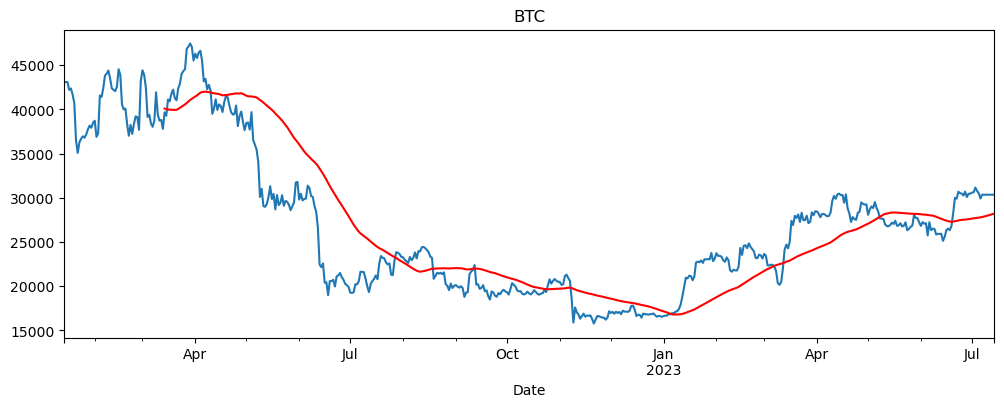

In [15]:
plt.rc('figure', figsize=(12, 4))
plt.title('BTC')
df['Price'].plot()
r = df['Price'].rolling(window=60)
rolling_mean = r.mean()
rolling_mean.plot(color='red')

Разложим временной ряд на компоненты: тренд, сезонность, шум.

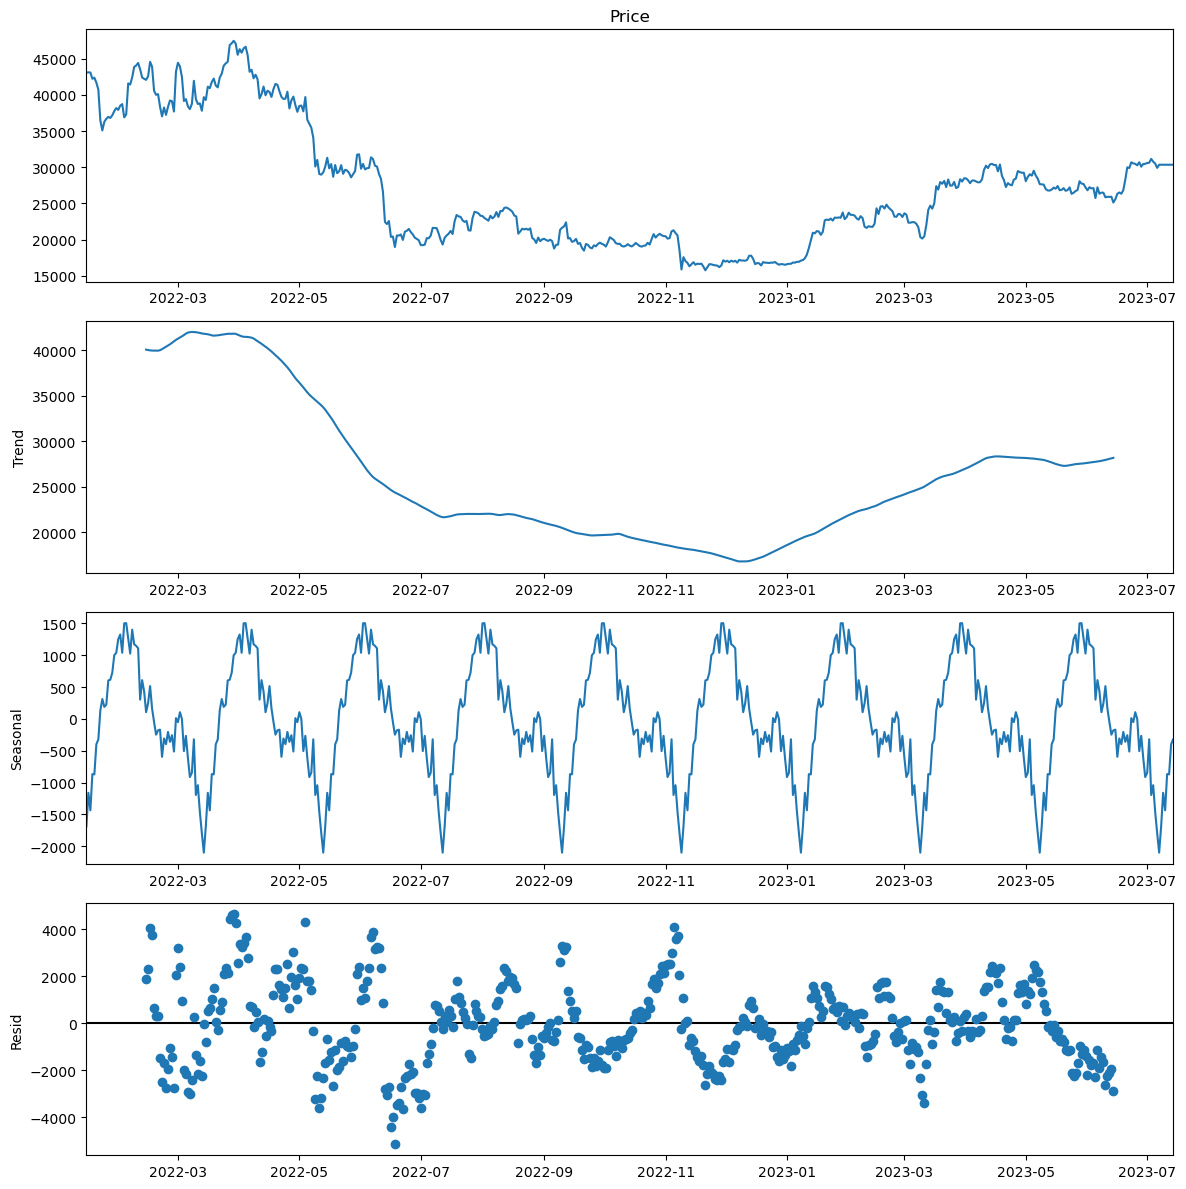

In [19]:
sd = seasonal_decompose(df['Price'], period=60, model='additive')
plt.rc('figure', figsize=(12, 12))
sd.plot()
plt.show()

## 2. Лаги и новые признаки

In [33]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [118]:
def preprocess_data(data, lag_start=7, lag_end=14, test_size=0.035):

    data = pd.DataFrame(data.copy())

    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    if test_size<1:
        test_index = int(len(data) * (1 - test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data[f"lag_price_{i}"] = data.Price.shift(i)
    
    data["day"] = data.index.day

    # считаем средние только по тренировочной части, чтобы избежать лика (data leak)
    if test_size<1:
        data["day_average"] = list(map(code_mean(data[:test_index], "day", "Price").get, data.day))
    else:
        data["day_average"] = list(map(code_mean(data[:-test_size], "day", "Price").get, data.day))

    # выкидываем закодированные средними признаки
    data.drop(["day"], axis=1, inplace=True)

    #TEST
    data.drop(['Volume'],axis=1,inplace=True)

    data = data.dropna()

    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    if test_size<1:
        X_train = data.iloc[:test_index].drop(["Price"], axis=1)
        y_train = data.iloc[:test_index]["Price"]
        X_test = data.iloc[test_index:].drop(["Price"], axis=1)
        y_test = data.iloc[test_index:]["Price"]
    else:
        X_train = data.iloc[:-test_size].drop(["Price"], axis=1)
        y_train = data.iloc[:-test_size]["Price"]
        X_test = data.iloc[-test_size:].drop(["Price"], axis=1)
        y_test = data.iloc[-test_size:]["Price"]

    return X_train, X_test, y_train, y_test

## 3.0 Наивная модель (Baseline). Score: 609.25714

In [114]:
df_ts=pd.DataFrame(df.copy())
df_ts=df_ts.reset_index()
df_ts['Date'] = pd.to_datetime(df_ts['Date'], format = '%b %d, %Y')
df_ts.drop(columns=['Open','High','Low','Volume','Change_percents'], inplace=True)

In [118]:
df_ts["timestamp"] = pd.to_datetime(df_ts["Date"])
df_ts["target"] = df_ts["Price"]
df_ts.drop(columns=["Date", 'Price'], inplace=True)
df_ts["segment"] = "main"
df_ts = TSDataset.to_dataset(df_ts)
ts = TSDataset(df_ts, freq="D")

train_ts, test_ts = ts.train_test_split(
    train_start="2022-01-14",
    train_end="2023-07-07",
    test_start="2023-07-08",
    test_end="2023-07-14",
)

In [121]:
naive=NaiveModel(lag=7)
naive.fit(train_ts)

future_ts = train_ts.make_future(future_steps=7, tail_steps=naive.context_size)
forecast_ts = naive.forecast(future_ts, prediction_size=7)

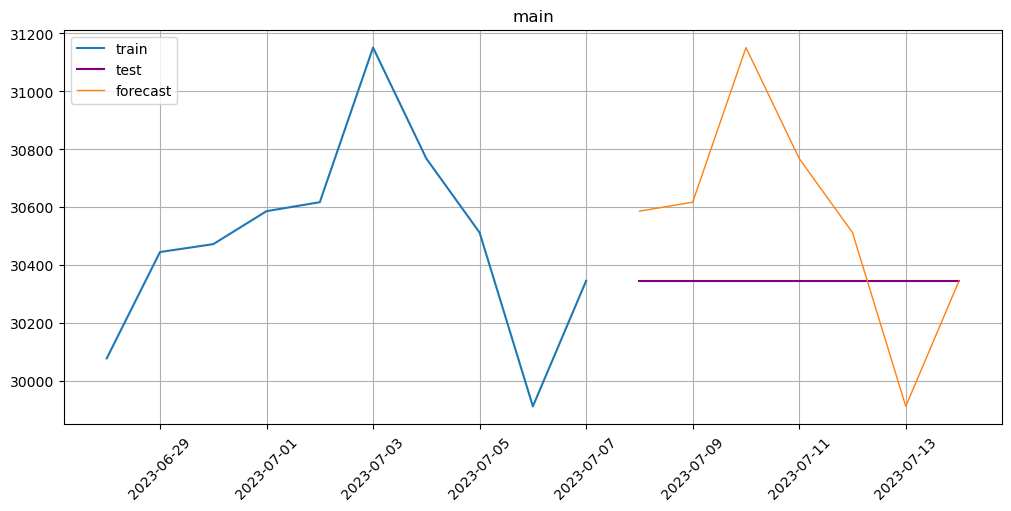

In [124]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

In [165]:
preds = forecast_ts.df['main']['target']
preds = preds.to_frame()
preds = preds.rename(columns={'target': 'Price'})
preds = preds.reset_index()
preds = preds.rename(columns={'timestamp': 'Date'})
preds.set_index('Date', inplace=True)

In [166]:
preds

,Price
Date,
2023-07-08,30586.8
2023-07-09,30617.7
2023-07-10,31151.3
2023-07-11,30768.4
2023-07-12,30512.8
2023-07-13,29913.1
2023-07-14,30346.4


In [168]:
preds[['Price']].to_csv('naive_baseline.csv')

Этот сабмит получил $609.25714$ score.

## 3.1 Линейная модель (Baseline). Score: 431.31707

In [123]:
X_train, X_test, y_train, y_test = preprocess_data(df, 7, 14, 0.035)

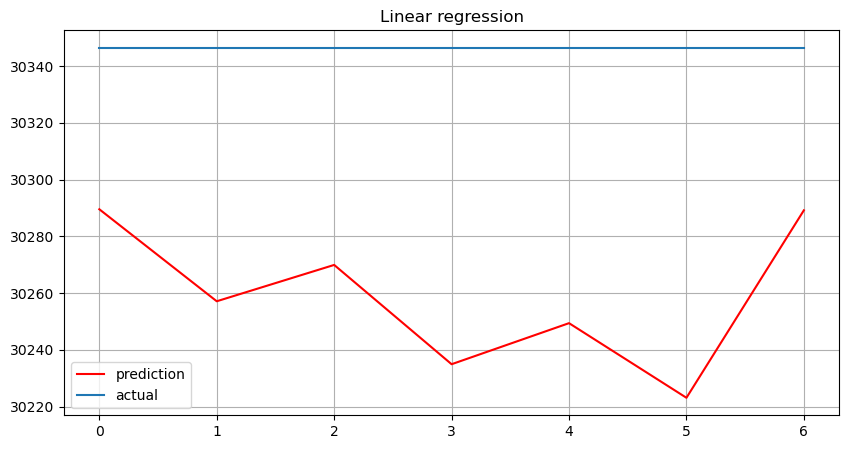

In [124]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

preds = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression");

In [125]:
kaggle(preds,"prediction_baseline_linear_regression.csv")

                   Price
Date                    
2023-07-08  30289.516730
2023-07-09  30257.112742
2023-07-10  30269.910750
2023-07-11  30234.936909
2023-07-12  30249.400578
2023-07-13  30223.115267
2023-07-14  30289.146451


Этот сабмит получил $431.31707$ score.

## 4. Бустинг. Score: 509.4987

In [25]:
from catboost import CatBoostRegressor

In [140]:
TEST_SIZE=7

In [141]:
validation_df=df[:-TEST_SIZE]

In [142]:
def cross_validation(params, data, folds=5):
    # подбираемые параметры
    lag_start, lag_end = params

    # вектор метрик для каждой из валидаций
    scores = []

    for shift in range(folds):
        # выбираем данные, сдвигая окно
        shift_size = shift * TEST_SIZE
        if shift_size == 0:
            data_cv = data
        else:
            data_cv = data[:-shift_size]

        # выделяем тренировочную и валидационную части
        X_train, X_valid, y_train, y_valid = preprocess_data(data_cv, lag_start, lag_end, TEST_SIZE)

        # обучаем модель, считаем метрику
        model=CatBoostRegressor(n_estimators=600, verbose=False, random_seed=42)
        model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=False)
        y_pred = model.predict(X_valid)
        mae = mean_absolute_error(y_valid, y_pred)
        scores.append(mae)

    cv_score = np.mean(np.array(scores))

    # возвращаем среднее значение метрики
    return cv_score

In [143]:
def model_optimize(data, params, verbose=False):
    best_params = [0, 0]
    best_score = 0
    params_stat = {
        'start': {},
        'end': {}
    }
    params_stat_count = {
        'start': 0,
        'end': 0
    }
    params_grid = {}

    # интервал и шаг параметров
    start_range, end_range = params

    # перебираем значения параметров и записываем среднюю метрику для кросс-валидации
    for end in range(end_range[0], end_range[1] + end_range[2], end_range[2]):

        for start in range(start_range[0], start_range[1] + start_range[2], start_range[2]):

            mae = cross_validation([start, end], data, folds=10)

            if best_score == 0 or (best_score > 0 and mae < best_score):
                best_score = mae
                best_params = [start, end]

            start_index = str(start)
            if start_index in params_stat['start']:
                params_stat['start'][start_index] += mae
            else:
                params_stat['start'][start_index] = mae
                params_stat_count['end'] += 1

            end_index = str(end)
            if end_index in params_stat['end']:
                params_stat['end'][end_index] += mae
            else:
                params_stat['end'][end_index] = mae
                params_stat_count['start'] += 1

            if end not in params_grid:
                params_grid[end] = {}
            params_grid[end][start] = mae

            if verbose:
                print(f"{start}-{end}: {mae:0.2f}")

    # вычисляем среднее значение для каждого варианта параметра
    for sk, sv in params_stat.items():
        params_stat[sk] = {k: v / params_stat_count[sk] for k, v in sv.items()}

    # возвращаем лучшую метрику, лучший набор параметров, средние метрики, а также матрицу метрик для сочетаний параметров
    return best_score, best_params, params_stat, params_grid

In [144]:
# запускаем подбор параметров
best_score, best_params, params_stat, params_grid = model_optimize(validation_df, [[7, 10, 1], [15, 35, 5]], verbose=True)

# лучшие параметры
lag_start_min, lag_end_min = best_params

# оптимальные параметры
lag_start_opt = int(min(params_stat['start'], key=params_stat['start'].get))
lag_end_opt = int(min(params_stat['end'], key=params_stat['end'].get))

7-15: 298.73
8-15: 277.48
9-15: 240.08
10-15: 224.43
7-20: 307.26
8-20: 254.88
9-20: 243.73
10-20: 273.45
7-25: 273.40
8-25: 214.45
9-25: 282.88
10-25: 256.61
7-30: 313.11
8-30: 329.70
9-30: 264.63
10-30: 255.83
7-35: 243.55
8-35: 235.65
9-35: 255.53
10-35: 251.34


In [145]:
print(f'Folds: {10}\nBest score: {best_score:0.2f}\nBest parameters: lag_start = {lag_start_min}, lag_end = {lag_end_min}\n' \
      f'Optimal parameters: lag_start = {lag_start_opt}, lag_end = {lag_end_opt}')

Folds: 10
Best score: 214.45
Best parameters: lag_start = 8, lag_end = 25
Optimal parameters: lag_start = 10, lag_end = 35


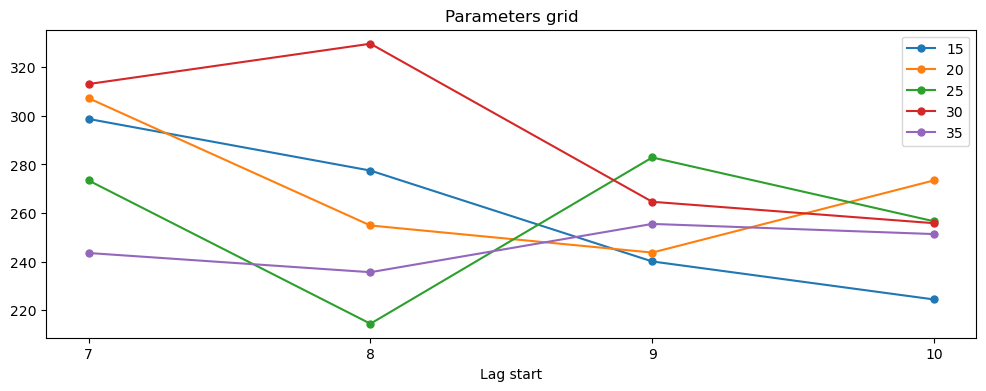

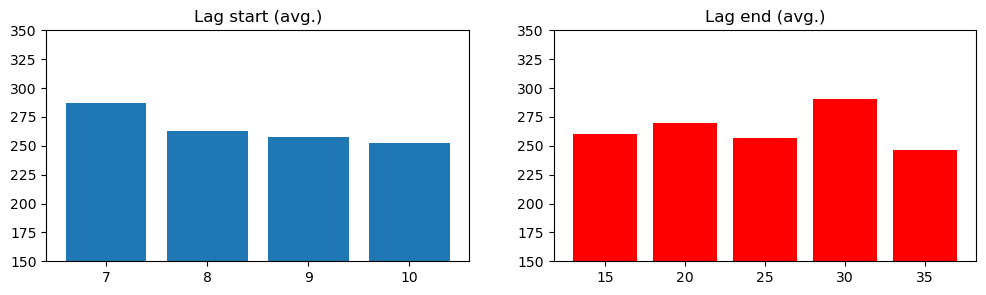

In [146]:
plt.figure(figsize=(12, 4))
plt.title(f'Parameters grid');
for lag_end_key, lag_end_set in params_grid.items():
    plt.plot(list(params_grid[lag_end_key].keys()), list(params_grid[lag_end_key].values()), 'o-', label=lag_end_key, markersize=5)
    plt.legend(loc='upper right')
    plt.xticks(list(params_grid[lag_end_key].keys()))
    plt.xlabel('Lag start')

plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 3))

ax[0].bar(list(params_stat['start'].keys()), list(params_stat['start'].values()))
ax[0].set_xticks(list(params_stat['start'].keys()))
ax[0].set_title(f'Lag start (avg.)');
ax[0].set_ylim([150, 350])

ax[1].bar(list(params_stat['end'].keys()), list(params_stat['end'].values()), color='r')
ax[1].set_xticks(list(params_stat['end'].keys()))
ax[1].set_title(f'Lag end (avg.)');
ax[1].set_ylim([150, 350])

plt.show()

In [147]:
X_train, X_test, y_train, y_test = preprocess_data(df, lag_start=10, lag_end=35, test_size=7)

In [148]:
model=CatBoostRegressor(n_estimators=600, verbose=False, random_seed=42)
model.fit(X_train, y_train)
preds=model.predict(X_test)

In [149]:
kaggle(preds,"prediction_catboost_regressor.csv")

                   Price
Date                    
2023-07-08  30131.155070
2023-07-09  30172.922875
2023-07-10  30089.303601
2023-07-11  30095.252680
2023-07-12  30036.480560
2023-07-13  29908.488032
2023-07-14  30120.571635


Данная посылка дала результат на kaggle $586.91018$.

Попробуем послать "лучшие" параметры кроссвалидации.

In [203]:
X_train, X_test, y_train, y_test = preprocess_data(df, lag_start=8, lag_end=25, test_size=7)
model=CatBoostRegressor(n_estimators=600, verbose=False, random_seed=42)
model.fit(X_train, y_train)
preds=model.predict(X_test)
kaggle(preds,"prediction_catboost_regressor.csv")

                   Price
Date                    
2023-07-08  30199.533247
2023-07-09  29947.374646
2023-07-10  29941.935929
2023-07-11  30344.564476
2023-07-12  30367.135513
2023-07-13  30307.460163
2023-07-14  29976.005118


Эта посылка дала рузльтат $509.4987$

## 5. ETS-модель (exponential smoothing). Score: 240.52496

Имеет смысл опробовать ETS-модель, поскольку ряд не стационарный, присутствует тренд и сезонность.

In [205]:
from statsmodels.tsa.api import ExponentialSmoothing

In [213]:
ets_model_s9 = ExponentialSmoothing(
    df['Price'],
    seasonal_periods=9,
    damped_trend=False,
    trend="additive",
    seasonal="multiplicative",
    use_boxcox=True,
    initialization_method="estimated",
).fit()

In [214]:
preds= ets_model_s9.forecast(7)
kaggle(preds.values,'ets_model_s9.csv')

                   Price
Date                    
2023-07-08  30489.576746
2023-07-09  30488.909795
2023-07-10  30641.863768
2023-07-11  30590.835464
2023-07-12  30425.786022
2023-07-13  30351.856567
2023-07-14  30825.413910


Этот сабмит получил score $344.56148$.

In [215]:
ets_model_s12 = ExponentialSmoothing(
    df['Price'],
    seasonal_periods=12,
    damped_trend=False,
    trend="additive",
    seasonal="multiplicative",
    use_boxcox=True,
    initialization_method="estimated",
).fit()

In [216]:
preds= ets_model_s12.forecast(7)
kaggle(preds.values,'ets_model_s12.csv')

                   Price
Date                    
2023-07-08  30415.456692
2023-07-09  30072.908911
2023-07-10  30090.708954
2023-07-11  30300.563701
2023-07-12  30705.705527
2023-07-13  31185.070756
2023-07-14  31519.064864


Этот сабмит получил score $240.52496$.